# Data collation

## Combine the BISAC and summaries datasets

Only take summaries that are of type "Main Description" and from "Publisher", "Ingram", or "Ingram Syndetics"

The single HTML sumamry that triggers a warning: `html_to_text(merged_df["annot"][11138])` (although this is not actually a problem)

In [21]:
import pandas as pd
from bs4 import BeautifulSoup
import swifter
from tqdm import tqdm

tqdm.pandas()

file1 = pd.read_csv("initial_data/Dartmount_subjects.txt", sep="|")
file1["isbn"] = file1["isbn13"].astype(str)
file1.drop(columns=["isbn13"], inplace=True)

file2 = pd.read_csv("initial_data/Dartmount_summaries.txt", sep="|")
file2["isbn"] = file2["isbn13"].astype(str)
file2.drop(columns=["isbn13"], inplace=True)

merged_df = pd.merge(file1, file2, on="isbn")

merged_df["bisacs"] = merged_df["BISAC"].str.split("#")
merged_df.drop(columns=["BISAC"], inplace=True)


def get_text(content):
    soup = BeautifulSoup(content)
    return soup.get_text(separator="\n", strip=True)


merged_df["summary"] = merged_df["annot"].swifter.apply(get_text)
merged_df.drop(columns=["annot"], inplace=True)

Pandas Apply:   7%|▋         | 11000/148409 [00:02<00:38, 3549.24it/s]/tmp/ipykernel_3942329/79602728.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content)
Pandas Apply: 100%|██████████| 148409/148409 [00:31<00:00, 4666.61it/s]


In [22]:
print(merged_df["annot_source"].value_counts(normalize=True), "\n\n")
print(merged_df["annot_type"].value_counts(normalize=True))

print(merged_df.shape)
merged_df = merged_df[merged_df["annot_type"] == "Main Description"]
print(merged_df.shape)
merged_df = merged_df[
    merged_df["annot_source"].isin(["Publisher", "Ingram", "Ingram Syndetics"])
]
print(merged_df.shape)
merged_df.drop(columns=["annot_source", "annot_type"], inplace=True)
merged_df

annot_source
Ingram                              0.437138
Publisher                           0.417434
Ingram Syndetics                    0.140239
Syndetics                           0.001900
Blackwell                           0.001584
Bowker Staff                        0.000539
Rittenhouse                         0.000478
DILVE - Spanish ISBN Agency         0.000323
BOC                                 0.000101
German - Libri                      0.000081
UK Video for Syndetics              0.000040
Swedish -  BTJ                      0.000027
Library Journal                     0.000027
British Library                     0.000027
New Zealand Summary                 0.000027
English - Libri                     0.000020
Best Books for Children, 5th ed.    0.000007
Thorpe                              0.000007
Name: proportion, dtype: float64 


annot_type
Main Description               0.956094
Author Affiliation             0.038057
Long Description               0.005337
Un-Paid An

,isbn,bisacs,summary
0,9780001847118,"[JUV037000, YAF019000, JUV001000, JUV000000, J...",This is a fantasy adventure by Alan Garner.
1,9780002006781,[HEA042000],"In those first heady days of a relationship, c..."
2,9780002007580,"[TRU001000, HIS037070]","In 1972, 11 Israeli athletes were murdered at ..."
3,9780002007801,[CKB000000],Watch a video trailer for The Devil's Picnic\n...
4,9780002189613,[SPO000000],In a world where it is becoming increasingly d...
...,...,...,...
148402,9789888273454,"[TRV003050, HIS021000]",A breathtaking romp through the city's Tokyo's...
148403,9789888422609,"[HIS021000, HIS003000]",Somebody knew. Who knew? Did Winston Churchill...
148405,9789927101892,[FIC019000],A Sudanese writer begins to suspect that one o...
148407,9789992194287,[FIC019000],When an opulent palace is built on the Jeddah ...


## Genre calculation

- FIC030... and FIC031... are both  Thrillers, so we combine

In [23]:
genre_dict = {
    "CKB": "Cooking",
    "JUV": "Juvenile Fiction",
    "HIS": "History",
    "YAF": "Young Adult Fiction",
    "BUS": "Business & Economics",
    "BIO": "Biography & Autobiography",
    "TRV": "Travel",
    "COM": "Comics & Graphic Novels",
    "FIC028": "Science Fiction",
    "FIC014": "Historical Fiction",
    "FIC004": "Classics",
    "FIC009": "Fantasy",
    "FIC027": "Romance",
    "REL": "Religion",
    "FIC022": "Mystery & Detective",
    "POE": "Poetry",
    "FIC019": "Literary Fiction",
    "POL": "Political Science",
    "PHI": "Philosophy",
    "SOC": "Social Science",
    "SCI": "Science",
    "HEA": "Health & Fitness",
    "FIC000": "General Fiction",
    "FIC031": "Thrillers",
    "FIC030": "Thrillers",
    "JNF": "Juvenile Nonfiction",
    "CRA": "Crafts & Hobbies",
    "LIT": "Literary Criticism",
    "SPO": "Sports & Recreation",
    "ART": "Art",
    "DRA": "Drama",
    "SEL": "Self-Help",
    "OCC": "Body, Mind & Spirit",
    "PSY": "Psychology",
    "PER": "Performing Arts",
    "MUS": "Music",
    "MED": "Medical",
    "FIC": "Fiction",
}

Pandas Apply: 100%|██████████| 141696/141696 [00:00<00:00, 380527.91it/s]


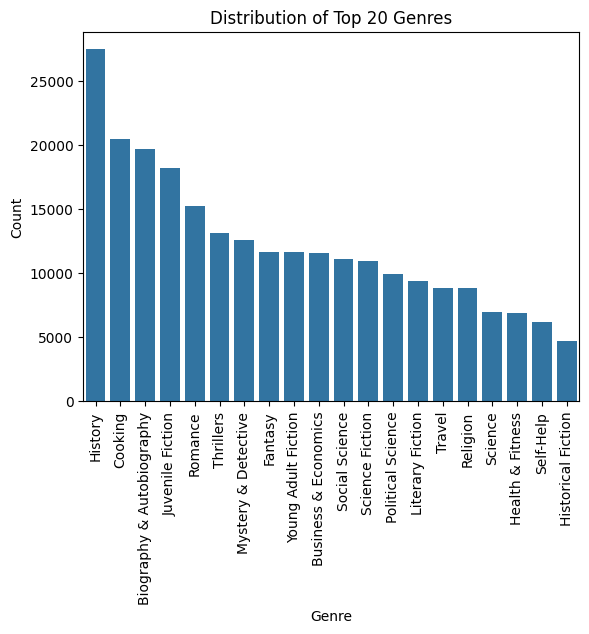

In [24]:
from collections import Counter, defaultdict
import random
import pandas as pd
import swifter
import ast


NOT_TOP_20 = "not_top_20"


def get_genre(bisac, subdivide_fiction=True):
    bisac = str.upper(bisac)
    if bisac[:3] == "FIC" and subdivide_fiction:
        bisac = bisac[:6]
    else:
        bisac = bisac[:3]
    return genre_dict.get(bisac, NOT_TOP_20)


genres = merged_df["bisacs"].swifter.apply(lambda x: [get_genre(bisac) for bisac in x])
genres = genres.tolist()
genres = [set(genres_inner) for genres_inner in genres]
combined = [genre for genres_inner in genres for genre in genres_inner]
unique_genres = list(set(combined))

genre_counts = defaultdict(int)
for genre_inner in genres:
    for genre in genre_inner:
        genre_counts[genre] += 1
genre_counts.pop(NOT_TOP_20)

genre_counts = sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)
top_genres = [genre for genre, count in genre_counts[:20]]


def get_top_genres(genres):
    genres_in_top_genres = []
    for genre in genres:
        if genre in top_genres:
            genres_in_top_genres.append(genre)
    return genres_in_top_genres


merged_df["genres"] = (
    merged_df["bisacs"]
    .swifter.apply(lambda x: [get_genre(bisac) for bisac in x])
    .swifter.apply(get_top_genres)
)
merged_df.drop(columns=["bisacs"], inplace=True)
merged_df = merged_df[merged_df["genres"].map(len) > 0]

import matplotlib.pyplot as plt
import pandas as pd
import ast
import seaborn as sns

combined = [genre for genres_inner in merged_df["genres"] for genre in genres_inner]
sns.countplot(x=combined, order=pd.Series(combined).value_counts().index)
plt.title("Distribution of Top 20 Genres")
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

## Add text excerpts to the dataframe

In [25]:
import ast
import random
from tqdm import tqdm

# only sample 15000 to compute faster; we're sampling 10,000 later anyway
# some books are insufficently long, so we oversample here
sampled_df = merged_df.sample(15000)

df_filename_isbns = pd.read_csv("initial_data/filename_isbns.csv")

filenames = []
isbns = []
for i, row in tqdm(
    df_filename_isbns.iterrows(),
    total=len(df_filename_isbns),
    desc="creating filename to isbn dict",
):
    filenames.append(row["filename"])
    isbn_1d = ast.literal_eval(row["isbns"])
    if len(isbn_1d) == 1 or len(str(isbn_1d[0])) == 13:
        isbns.append(isbn_1d[0])
    else:
        isbn_1d = [str(isbn) for isbn in isbn_1d]
        isbn_1d.sort(key=len, reverse=True)
        isbns.append(isbn_1d[0])

isbn_to_filename = {str(isbn): filename for isbn, filename in zip(isbns, filenames)}


def get_text(isbn):
    n_chunks = 10
    chunk_len = 500

    isbn = str(isbn)
    try:
        filename = isbn_to_filename[isbn]
        with open(f"initial_data/books3/{filename}", "r") as f:
            full_text = f.read()
        words = full_text.split()
        n_words = len(words)
        if n_words < n_chunks * chunk_len:
            return None

        chunks = [(i, words[i : i + chunk_len]) for i in range(0, n_words, chunk_len)]

        sampled_chunks = random.sample(chunks, n_chunks)
        sampled_chunks.sort(key=lambda x: x[0])
        combined = [word for i, chunk in sampled_chunks for word in chunk]
        combined_str = " ".join(combined)
        return combined_str

    except Exception as e:
        print(f"Error processing ISBN {isbn}: {e}")
        return None

creating filename to isbn dict: 100%|██████████| 174918/174918 [00:11<00:00, 14912.87it/s]


In [26]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import os


isbns = sampled_df["isbn"].tolist()

with Pool(processes=os.cpu_count()) as pool:
    texts = list(tqdm(pool.imap(get_text, isbns), total=len(isbns)))

sampled_df["text"] = texts

100%|██████████| 15000/15000 [01:14<00:00, 201.02it/s]


## Sample 10000 books

In [27]:
sampled_df = sampled_df.dropna(subset=["text", "summary"])
sampled_df = sampled_df.sample(10000)

## Split into train and test 


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

train, test = train_test_split(sampled_df, test_size=0.2, random_state=42)
train_index = train.index
sampled_df["split"] = "test"
sampled_df.loc[train_index, "split"] = "train"

sampled_df.to_csv("data/data.csv", index=False)
sampled_df

,isbn,summary,genres,text,split
28783,9780316254045,The stunning new novel by the author of Sway i...,"[Literary Fiction, Historical Fiction]",a brave thing just to take them down and give ...,test
50425,9780743254533,Mark Sundeen needed to stage a comeback. His f...,"[Biography & Autobiography, Biography & Autobi...",we'd shipped three hundred copies. We could no...,train
42275,9780525621645,NATIONAL BESTSELLER - For women approaching or...,"[Health & Fitness, Cooking, Health & Fitness]",condition or have any symptom that may require...,train
114519,9781590513286,"An entertaining exploration of the myths, clai...","[Cooking, Science, Health & Fitness]",means that two of these bars a day contain an ...,test
44172,9780553900101,"Filled with exciting tales of the frontier, th...",[Historical Fiction],of questionable activities. Fanny Baston did n...,train
...,...,...,...,...,...
121526,9781612381053,Canada resident and avid outdoorsman Andrew He...,[Travel],guides. **Yamnuska** (403/678-4164 or 866/678-...,train
38396,9780446569439,Beginning in Ireland in the early years of the...,"[Literary Fiction, Historical Fiction]",it? To have it locked in there night after nig...,train
1998,9780008203771,'Do yourself a favour and read this wonderful ...,"[Historical Fiction, Literary Fiction]",you know she's called Marusya?' asks Masha. 'U...,train
95262,9781462903467,Today people around the world are discovering ...,"[Self-Help, Self-Help]",helping maintain the structural balance of the...,test


In [29]:
sampled_df["text"].apply(lambda x: len(x.split())).value_counts()

text
5000    9176
4928       8
4570       5
4829       5
4911       5
        ... 
4984       1
4517       1
4921       1
4769       1
4646       1
Name: count, Length: 416, dtype: int64

# Vectorizing

## Doc2vec model training

With parameter `min_count=2`; besides that, unlimited vocabulary size

In [1]:
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import pandas as pd


def create_model(df, column_name):
    model = Doc2Vec(
        vector_size=100,
        window=5,
        alpha=0.025,
        min_alpha=0.00025,
        seed=42,
        dm=1,
        dm_concat=1,
        workers=os.cpu_count(),
        epochs=100,
        min_count=2,
    )

    tagged_data = [
        TaggedDocument(
            words=word_tokenize(doc.lower()),
            tags=[str(i)],
        )
        for i, doc in tqdm(
            enumerate(df[column_name]), total=len(df), desc=f"tagging {column_name}"
        )
    ]

    model.build_vocab(tagged_data)
    model.train(
        tagged_data,
        total_examples=model.corpus_count,
        epochs=model.epochs,
        report_delay=1,
    )

    return model


df = pd.read_csv("data/data.csv")
train = df[df["split"] == "train"]

create_model(train, "summary").save("doc2vec_models/summary.model")
create_model(train, "text").save("doc2vec_models/text.model")

tagging text: 100%|██████████| 8000/8000 [03:53<00:00, 34.33it/s]


## Doc2vec vectorizing

In [ ]:
import multiprocessing
import pandas as pd
from gensim.models import Doc2Vec
import pandas as pd
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec
from nltk.tokenize import word_tokenize


df = pd.read_csv("data/data.csv")
train = df[df["split"] == "train"]


def vectorize_text(text):
    model = Doc2Vec.load(f"doc2vec_models/{column_name}.model")
    return model.infer_vector(word_tokenize(text.lower()))


for column_name in ["summary", "text"]:
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_cores)

    df_vectorized = pd.DataFrame(pool.map(vectorize_text, df[column_name]))
    pool.close()
    pool.join()

    df_vectorized.to_csv(f"data/doc2vec_{column_name}.csv", index=False)

## TF-IDF

min_df=2, vocabulary size limit = 25000 (vocabulary size would have been 404623 for text without these; kernel fails when trying to classify on that much data) 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pandas as pd


df = pd.read_csv("data/data.csv")
train = df[df["split"] == "train"]


for column_name in ["summary", "text"]:
    tfidf = TfidfVectorizer(max_features=25000, min_df=2)
    tfidf.fit(train[column_name])
    # print the size of the volcabulary
    print("vocab size", len(tfidf.vocabulary_))

    df_vectorized = pd.DataFrame(tfidf.transform(df[column_name]).todense())
    df_vectorized.columns = tfidf.get_feature_names_out()
    df_vectorized.to_csv(f"data/tfidf_{column_name}.csv", index=False)

vocab size 25000
vocab size 25000


# Clustering

## k-means

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_index = pd.read_csv("final_data/train_index.csv")["0"]
df = pd.read_csv("final_data/data.csv")
labels = df[df.index.isin(train_index)]["genre"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

fig.suptitle("k-means Clustering of Summary and Text using Doc2Vec and TF-IDF")

for i, column_name in enumerate(["summary", "text"]):
    for j, vectorizer_type in enumerate(["doc2vec", "tfidf"]):
        df_cur = pd.read_csv(f"final_data/{vectorizer_type}_{column_name}.csv")
        train = df_cur[df_cur.index.isin(train_index)]
        scaler = StandardScaler()
        train = scaler.fit_transform(train)

        kmeans = KMeans(n_clusters=33, random_state=42)
        clusters = kmeans.fit_predict(train)

        ari = adjusted_rand_score(labels, clusters)

        pca = PCA(n_components=2, random_state=42)
        train_pca = pca.fit_transform(train)
        explained_variance = pca.explained_variance_ratio_
        percentage_variance = sum(explained_variance[:2]) * 100

        ax = sns.scatterplot(
            data=pd.DataFrame(train_pca),
            x=train_pca[:, 0],
            y=train_pca[:, 1],
            hue=clusters,
            palette="tab10",
            ax=axes[i, j],
            legend=False,
        )

        ax.set_title(
            f"{column_name.capitalize()} ({vectorizer_type.capitalize()})\nARI: {ari:.2f}\n{percentage_variance:.2f}% of the variance\n"
        )
        ax.set_xlabel("PC 1")
        ax.set_ylabel("PC 2")

plt.tight_layout()
plt.savefig("clustering.png")
plt.show()

## Spectral

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import spectral_clustering
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

df = pd.read_csv("final_data/data.csv")
train_index = pd.read_csv("final_data/train_index.csv")["0"]
labels = df[df.index.isin(train_index)]["genre"]


for column_name in ["summary", "text"]:
    for vectorizer_type in ["tfidf", "doc2vec"]:
        df_vectorized = pd.read_csv(f"final_data/{vectorizer_type}_{column_name}.csv")
        train = df_vectorized[df_vectorized.index.isin(train_index)]
        scaler = StandardScaler()
        train = scaler.fit_transform(train)

        n_samples = 1000
        random_indices = np.random.choice(train.shape[0], n_samples, replace=False)
        train_sample = train[random_indices]
        labels_sample = labels.reset_index(drop=True)[random_indices]
        distances = pairwise_distances(train_sample, metric="euclidean")

        sigmas = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]

        for sigma in sigmas:
            affinity_matrix = rbf_kernel(distances, gamma=1 / (2 * sigma**2))
            degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))
            laplacian_matrix = degree_matrix - affinity_matrix
            eigenvalues = np.linalg.eigvals(laplacian_matrix)
            sorted_eigenvalues = np.sort(eigenvalues)
            plt.plot(sorted_eigenvalues, label=f"Sigma: {sigma}")

        plt.xlabel("Number of Eigenvalues")
        plt.ylabel("Eigenvalues")
        plt.title(
            f"Eigenvalues of Laplacian Matrix for {column_name.capitalize()} ({vectorizer_type.capitalize()})"
        )
        plt.legend()
        plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering


n_clusters = 11
sc = SpectralClustering(
    n_clusters=n_clusters,
    # n_components=n_clusters + 1,
    # affinity="rbf",
    affinity="nearest_neighbors",
    # gamma=1 / (2 * sigma**2),
    n_jobs=-1,
)

labels_pred = sc.fit_predict(train)
adjusted_rand_score(labels, labels_pred)

In [ ]:
from sklearn.cluster import KMeans


# get the 11 smallest eignevectors
smallest = np.linalg.eig(laplacian_matrix)[1][:, :11]

# run k-means on smallest
kmeans = KMeans(n_clusters=11, random_state=42)
clusters = kmeans.fit_predict(smallest)

ari = adjusted_rand_score(labels_200, clusters)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Initialize MDS and fit_transform the data
mds = MDS(n_components=2, random_state=42)
embedding = mds.fit_transform(smallest)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(11):
    plt.scatter(
        embedding[clusters == i, 0], embedding[clusters == i, 1], label=f"Cluster {i}"
    )
plt.title("MDS Plot of Clusters")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.show()

# Classification

## Multi-label predication via grid search over logistic regression

- log reg w/ max_iters = 1000
- scaled data
- c_params = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import ast
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/data.csv")
df["genres"] = df["genres"].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["genres"])
train_index = df[df["split"] == "train"].index
test_index = df[df["split"] == "test"].index
Y_train = Y[train_index]
Y_test = Y[test_index]


for column_name in ["summary", "text"]:
    for vectorizer_type in ["tfidf", "doc2vec"]:
        df_data = pd.read_csv(f"data/{vectorizer_type}_{column_name}.csv")
        X_train = df_data.loc[train_index]
        X_test = df_data.loc[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        logreg = LogisticRegression(max_iter=1000)
        multi_target_logreg = MultiOutputClassifier(logreg)
        c_params = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
        param_grid = {"estimator__C": c_params}
        grid_search = GridSearchCV(multi_target_logreg, param_grid, cv=5, n_jobs=-1)

        grid_search.fit(X_train, Y_train)
        print(column_name, vectorizer_type, grid_search.best_params_)
        best_estimator = grid_search.best_estimator_
        Y_pred_proba = best_estimator.predict_proba(X_test)

        save_path = f"probability_predictions/{vectorizer_type}_{column_name}.npy"
        np.save(save_path, Y_pred_proba)

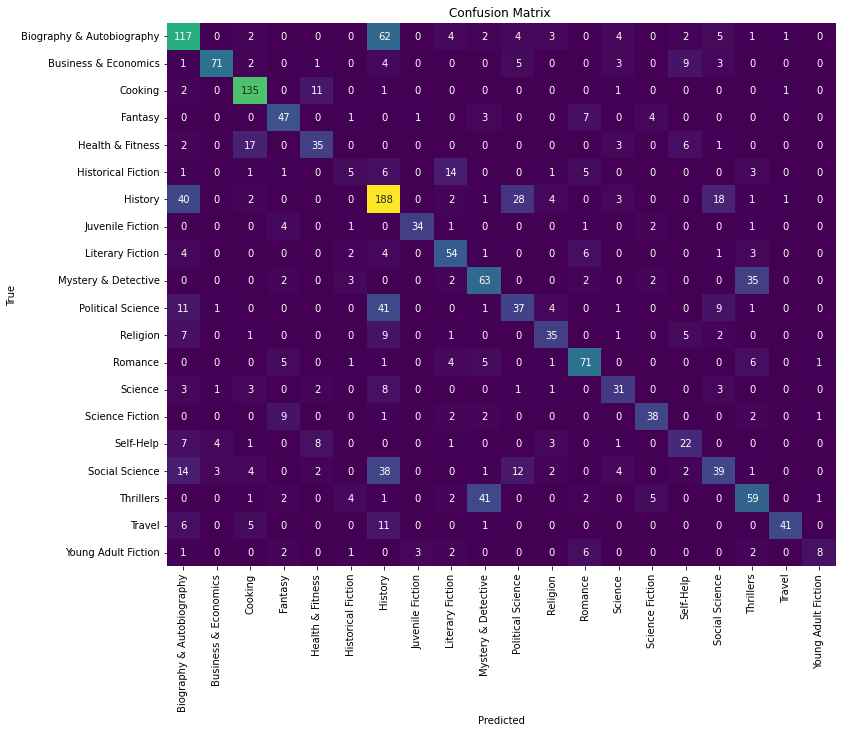

[[0.45703125 0.         0.4               nan 0.                nan
  0.82666667        nan        inf        inf 0.36363636 0.2
         nan 1.                nan 0.2        0.16129032        inf
  0.08333333        nan]
 [0.25       0.57723577 0.66666667        nan 0.5               nan
  0.5               nan        nan        nan 0.625             nan
         nan 0.6               nan 0.81818182 0.33333333        nan
  0.                nan]
 [0.4        0.         0.85987261        nan 0.61111111 0.
  0.5               nan        nan        nan        nan 0.
         nan 0.33333333        nan 0.         0.         0.
  0.2               nan]
 [       nan        nan        nan 0.40869565        nan 0.33333333
         nan        inf 0.         0.75              nan        nan
  0.33333333        nan 0.18181818        nan        nan 0.
         nan 0.        ]
 [0.66666667 0.         0.94444444        nan 0.47945205        nan
         nan        nan        nan        nan 0.       

/home2/hstropkay/76-final-project/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home2/hstropkay/76-final-project/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


TypeError: nan_to_num() got an unexpected keyword argument 'nan'

<Figure size 864x720 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Y_test = np.load("data/Y_test.npy")
Y_pred = np.load("data/predictions_tfidf_summary.npy")


def confusion_matrix_any(Y_test, Y_pred, normalize=False):
    matrix = np.dot(Y_test.T, Y_pred)
    if normalize:
        matrix = matrix / np.dot(Y_test.T, Y_test)
        matrix = np.nan_to_num(matrix, nan=0.0, posinf=0.0, neginf=0.0)
    return pd.DataFrame(matrix, index=mlb.classes_, columns=mlb.classes_)


for normalize in [False, True]:
    plt.figure(figsize=(12, 10))
    confusion_matrix = confusion_matrix_any(Y_test, Y_pred, normalize=normalize)
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.title(f"Confusion Matrix {'(Normalized)' if normalize else ''}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
""" Plot the confusion matrix
fig, axes = plt.subplots(nrows=len(cm), ncols=1, figsize=(8, 6*len(cm)))

for i, cm_per_class in enumerate(cm):
    class_name = f"Class {i}"
    sns.heatmap(cm_per_class, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {class_name}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()"""

In [23]:
def exact_match_ratio(Y_test, Y_pred):
    return np.all(Y_pred == Y_test, axis=1).mean()


def mean_accuracy(y_true, y_pred):
    correct_on_true = np.logical_and(y_true, y_pred)
    accuracies = correct_on_true.sum(axis=1) / y_true.sum(axis=1)
    return accuracies.mean()


def precision(y_true, y_pred):
    true_positives = np.logical_and(y_true, y_pred).sum(axis=0)
    false_positives = np.logical_and(np.logical_not(y_true), y_pred).sum(axis=0)
    return true_positives / (true_positives + false_positives)


def recall(y_true, y_pred):
    true_positives = np.logical_and(y_true, y_pred).sum(axis=0)
    false_negatives = np.logical_and(y_true, np.logical_not(y_pred)).sum(axis=0)
    return true_positives / (true_positives + false_negatives)


def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec)


print(exact_match_ratio(Y_test, Y_pred))

print(mean_accuracy(Y_test, Y_pred))

print(precision(Y_test, Y_pred))

print(recall(Y_test, Y_pred))

print(f1_score(Y_test, Y_pred))

# print the labels of Y_true
labels = mlb.inverse_transform(Y_test)
# for each genre, print the percent of books that have that genre
sum = 0
for genre in mlb.classes_:
    print(f"{genre}: {np.mean([genre in label for label in labels]):.2f}")
    sum += np.mean([genre in label for label in labels])
print(sum)

0.192
0.234875
[0.91025641 1.         0.96491228 0.90909091 0.94736842        nan
 0.7752809  1.         1.         0.88888889 0.75       0.9
 0.86363636 0.875      1.         0.625      0.7        0.93333333
 1.                nan]
[0.27734375 0.26829268 0.70063694 0.08695652 0.24657534 0.
 0.46621622 0.01923077 0.12195122 0.17142857 0.16981132 0.11392405
 0.24516129 0.09090909 0.11428571 0.05681818 0.03954802 0.08284024
 0.3125     0.        ]
[0.4251497  0.42307692 0.81180812 0.15873016 0.39130435        nan
 0.58227848 0.03773585 0.2173913  0.28742515 0.27692308 0.20224719
 0.38190955 0.16470588 0.20512821 0.10416667 0.07486631 0.15217391
 0.47619048        nan]
Biography & Autobiography: 0.13
Business & Economics: 0.06
Cooking: 0.08
Fantasy: 0.06
Health & Fitness: 0.04
Historical Fiction: 0.04
History: 0.15
Juvenile Fiction: 0.05
Literary Fiction: 0.08
Mystery & Detective: 0.07
Political Science: 0.05
Religion: 0.04
Romance: 0.08
Science: 0.04
Science Fiction: 0.05
Self-Help: 0.04

/home2/hstropkay/76-final-project/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


## PCA

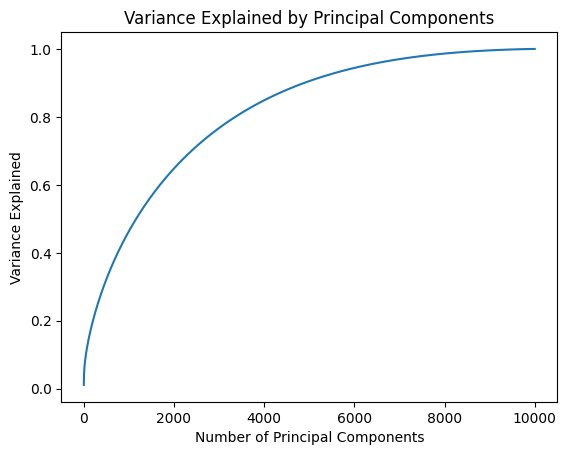

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca.fit(df_tfidf_summary)

# Calculate variance explained
variance_explained = np.cumsum(pca.explained_variance_ratio_)

# Plot variance explained
plt.plot(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Principal Components")
plt.show()

## Closer examination of TF-IDF on the summaries

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler


df = pd.read_csv(f"final_data/data.csv")


column_name = "summary"
vectorizer_type = "tfidf"
data = pd.read_csv(f"final_data/{vectorizer_type}_{column_name}.csv")
train_index = pd.read_csv("final_data/train_index.csv")["0"]
test_index = pd.read_csv("final_data/test_index.csv")["0"]
X_train = data[data.index.isin(train_index)]
X_test = data[data.index.isin(test_index)]
y_train = df[df.index.isin(train_index)]["genre"]
y_test = df[df.index.isin(test_index)]["genre"]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {"C": [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    n_jobs=os.cpu_count(),
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# show confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_model.classes_,
    yticklabels=best_model.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(
    f"Confusion Matrix of {column_name.capitalize()} using {vectorizer_type.capitalize()}"
)
plt.show()

In [ ]:
coefficients = best_model.coef_
feature_names = data.columns

coef_dict = {}
for genre, coef in zip(best_model.classes_, coefficients):
    coef_dict[genre] = dict(zip(feature_names, coef))


all_genres_coef = {
    (genre, feature, coef)
    for genre, coef_dict in coef_dict.items()
    for feature, coef in coef_dict.items()
}
top_features = sorted(all_genres_coef, key=lambda x: x[2], reverse=True)[:15]
top_features